In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "stomach_stomach_HCLFetalStomach1"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"),h = T,sep='\t',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


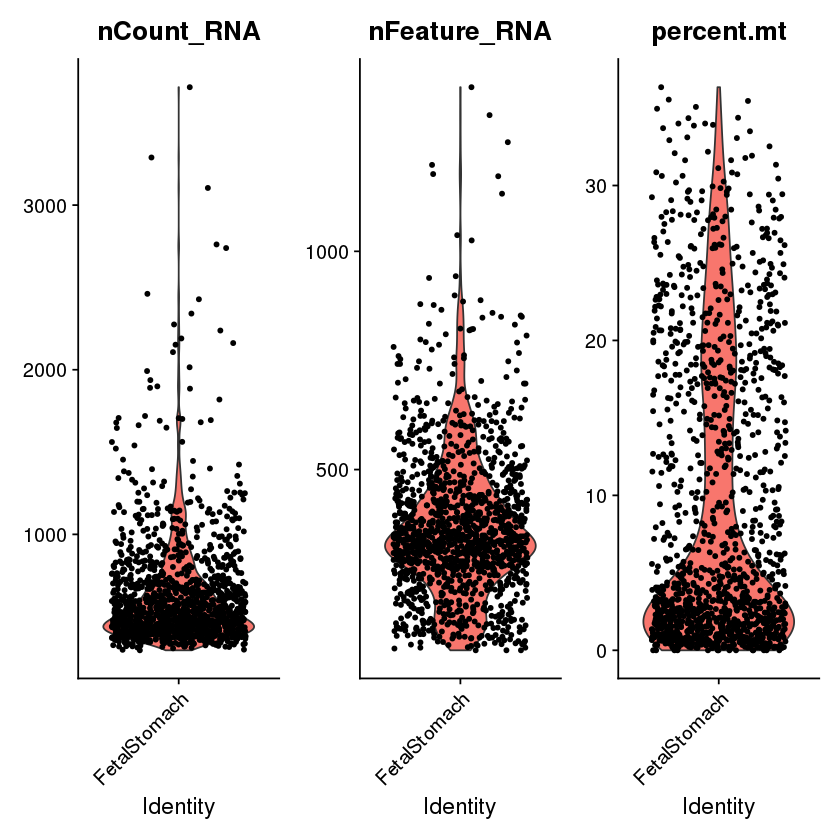

In [4]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [5]:
percent.mt.thre = 45
nFeature_RNA_range = c(min.features, 1000)
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [6]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [7]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 22227  1313
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "A1BG"     "A1BG-AS1" "A1CF"     "A2M"      "A2M-AS1" 
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 17920  1313
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  1313
[1] "Finished"


In [8]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

dataobj <- AddMetaData(dataobj, metadata = data.metadata)

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  HBG2, HBA2, HBA1, HBB, VIM, SPARC, HBG1, ALAS2, AHSP, A2M 
	   GNG11, LGALS1, HBZ, COL4A1, RAMP2, SOX4, TUBA1A, ESAM, IGFBP7, CAV1 
	   GYPB, CDH5, CD34, CD93, IGFBP4, STMN1, SLC4A1, PECAM1, SLC25A37, COL4A2 
Negative:  MT-RNR1, SPINK1, AGR2, MT-RNR2, FXYD3, MT-ND4, MT-CO3, MT-CO1, TFF1, ANXA10 
	   MT-CYB, MT-CO2, MT-TE, MT-ATP6, CLDN18, MSMB, MT-ND1, TSPAN8, S100P, TFF2 
	   MT-ND2, CTSE, CYSTM1, TXNIP, S100A6, MT1E, MT-TM, RPS19, GSTP1, TFF3 
PC_ 2 
Positive:  HBG2, HBA1, HBA2, HBB, AHSP, HBG1, ALAS2, HBZ, GYPB, GYPA 
	   BLVRB, SLC4A1, SLC25A37, HEMGN, PRDX2, BNIP3L, BPGM, HBZP1, HBE1, S100A4 
	   TENT5C, GMPR, TSPAN32, XPO7, PTTG1, TMSB15A, GAL, HEPH, COL1A1, LINC00682 
Negative:  A2M, CDH5, RAMP2, ESAM, VIM, COL4A1, CD34, CAV1, IGFBP7, CD93 
	   PECAM1, TMSB4X, GNG11, TMSB10, PLVAP, COL15A1, KDR, TM4SF1, COL4A2, TCIM 
	   IGFBP4, APLNR, B2M, MADCAM1, ITM2B, ANXA2, IGFBP3, FLT1, HSPG2, CLDN5 
PC_ 3 
Positive:  GAP43, STMN2, UCHL1, CARTPT, TUBB2B, MLLT11, RTN1, PE

png 
  2

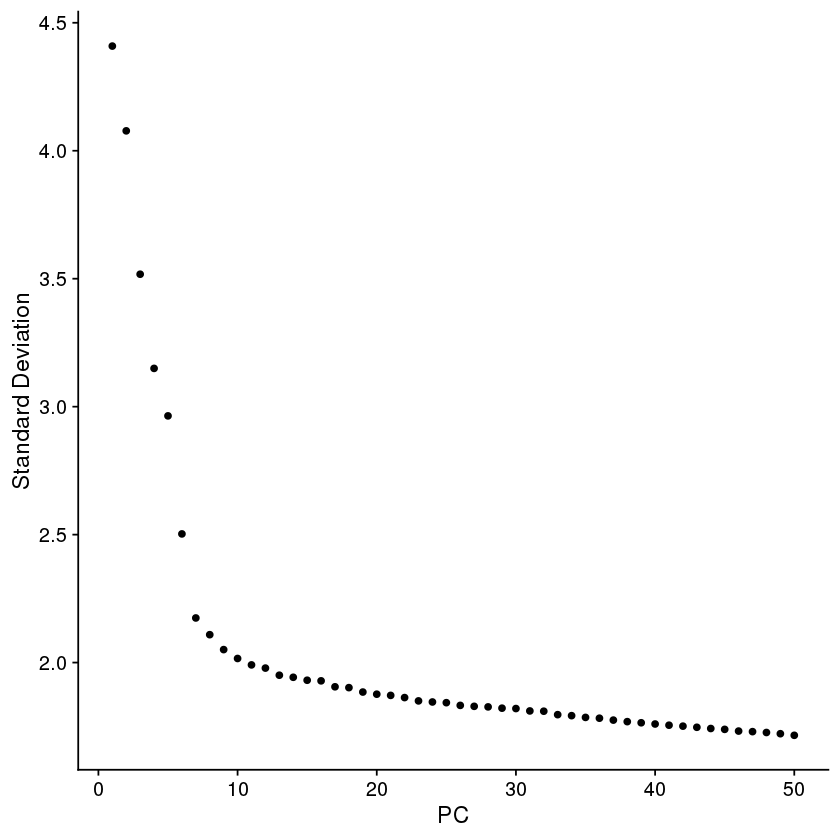

In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [10]:
pcDim = 40 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [11]:
dataobj <- FindClusters(dataobj, resolution = 2, n.start = 5)
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1313
Number of edges: 77969

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.5546
Number of communities: 12
Elapsed time: 0 seconds


ARI 
0.4774505

In [12]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:14:35 UMAP embedding parameters a = 0.9922 b = 1.112

11:14:35 Read 1313 rows and found 40 numeric columns

11:14:35 Using Annoy for neighbor search, n_neighbors = 30

11:14:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

11:14:36 Writing NN index file to temp file /tmp/Rtmp2UojWw/fileb59b1a355a7c

11:14:36 Searching Annoy index using 1 thread, search_k = 3000

11:14:36 Annoy recall = 100%

11:14:37 Commencing smooth kNN distance calibration using 1 thread

11:14:38 Initializing fr

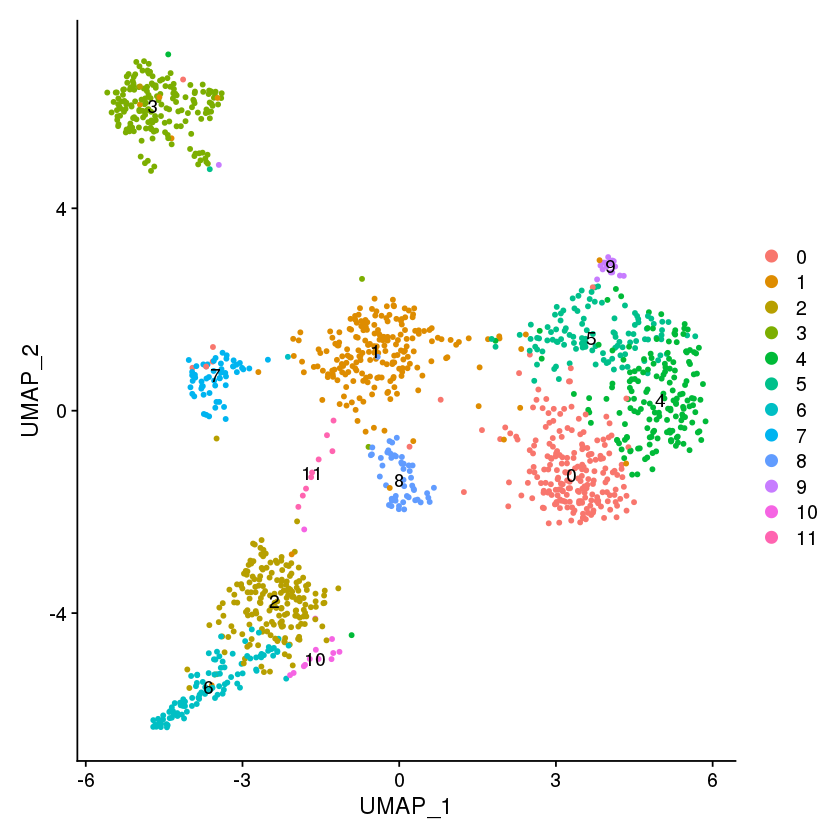

In [13]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

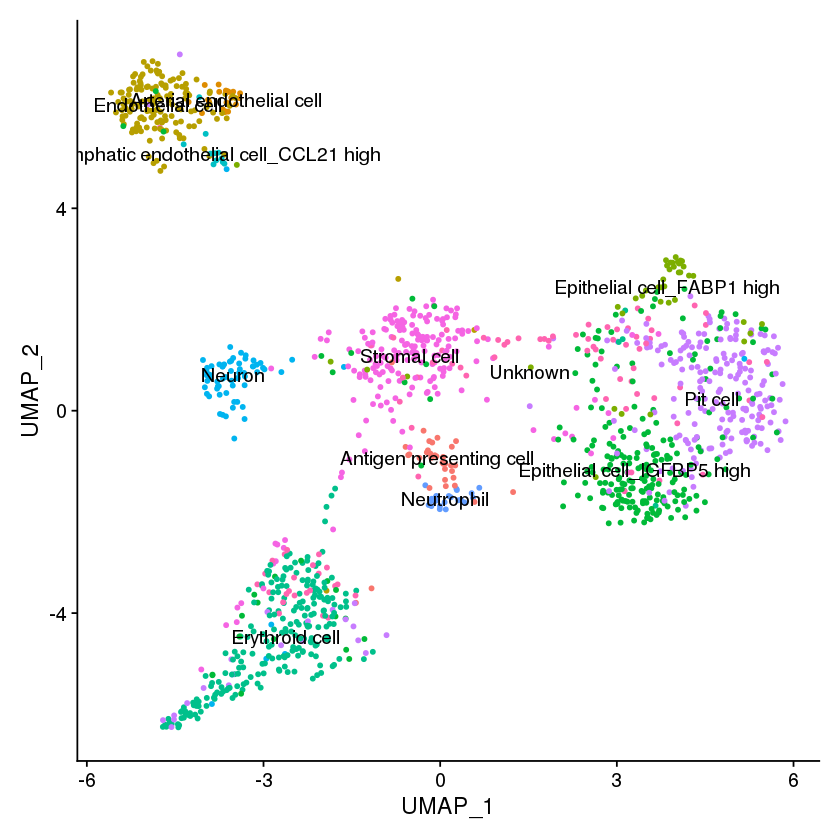

In [14]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [29]:
new.cluster.ids <- c("Stomach-Epithelial tissue-Epithelial cell-AGR2", 
                     "Stomach-Connective tissue-Stromal cell-DCN",
                     "Stomach-Connective tissue-Erythroid cell-HBB",
                     "Stomach-Epithelial tissue-Endothelial cell-IGFBP7", 
                     "Stomach-Epithelial tissue-Pit cell-TFF1", 
                     "Unknown", 
                     "Stomach-Connective tissue-Erythroid cell-HBB",
                     "Stomach-Nerve tissue-Neuron-STMN2",
                     "Stomach-Connective tissue-Antigen presenting cell-HLA-DRA",
                     "Stomach-Epithelial tissue-Epithelial cell-FABP1", 
                     "Stomach-Connective tissue-Erythroid cell-HBB",
                     "Stomach-Muscle tissue-Muscle cell-ACTA2"
                    )

In [28]:
subset(dataobj.markers,cluster=='12')
# subset(dataobj.markers,gene=='NUPR1')

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>


In [30]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [32]:
rr2 <- RunUMAP(annodataobj,dims=1:pcDim)

11:37:55 UMAP embedding parameters a = 0.9922 b = 1.112

11:37:55 Read 1313 rows and found 40 numeric columns

11:37:55 Using Annoy for neighbor search, n_neighbors = 30

11:37:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

11:37:56 Writing NN index file to temp file /tmp/Rtmp2UojWw/fileb59b7ff20ea4

11:37:56 Searching Annoy index using 1 thread, search_k = 3000

11:37:57 Annoy recall = 100%

11:37:57 Commencing smooth kNN distance calibration using 1 thread

11:37:58 Initializing from normalized Laplacian + noise

11:37:58 Commencing optimization for 500 epochs, with 58878 positive edges

11:38:03 Optimization finished



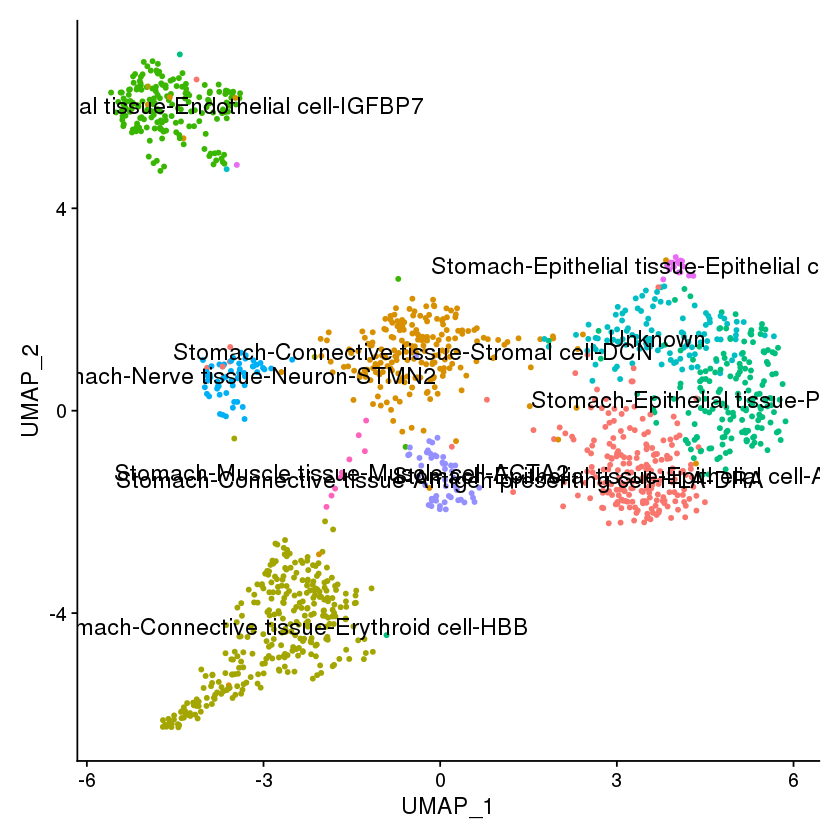

In [33]:
p_umap4 <- UMAPPlot(rr2,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [15]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [32]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(dataobj$seurat_clusters),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [34]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [35]:
dataobj

An object of class Seurat 
43878 features across 1313 samples within 1 assay 
Active assay: RNA (43878 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [36]:
# ncol(result_data_out
print(levels(dataobj$sample_status))
levels(dataobj$donor_age)    

[1] "normal"


[1] "7W"

In [37]:
levels(dataobj$donor_age)    <- c('GW7')

In [38]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-4"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Stomach"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"Microwell-seq"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj$donor_ID
dataobj.dbupload_v1$donor_gender<-dataobj$donor_gender
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [39]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)
dataobj.dbupload_v1$donor_age<- sub("Y","yr",dataobj.dbupload_v1$donor_age)


In [40]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [41]:
colnames(dataobj.dbupload_v1@meta.data)

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subregion"     "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [42]:
dataobj.dbupload_v1

An object of class Seurat 
43878 features across 1313 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [43]:
head(dataobj.dbupload_v1[[]],3)

,user_id,study_id,cell_id,organ,region,subregion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FetalStomach_1.CTCCATGGTACAGAGGAG,1,10.1038/s41586-020-2157-4,FetalStomach_1.CTCCATGGTACAGAGGAG,Stomach,NA,NA,Microwell-seq,Healthy,6,Male,GW7,Unknown,NA,Unknown
FetalStomach_1.CGCACCACGTTGCCTTTC,1,10.1038/s41586-020-2157-4,FetalStomach_1.CGCACCACGTTGCCTTTC,Stomach,NA,NA,Microwell-seq,Healthy,1,Male,GW7,Epithelial cell_IGFBP5 high,NA,Unknown
FetalStomach_1.CGCACCCCTAGACCGCTA,1,10.1038/s41586-020-2157-4,FetalStomach_1.CGCACCCCTAGACCGCTA,Stomach,NA,NA,Microwell-seq,Healthy,2,Male,GW7,Pit cell,NA,Unknown


In [44]:
unique(dataobj.dbupload_v1$hcad_name)

[1] "Unknown"                                                  
 [2] "Stomach-Connective tissue-Erythroid cell-HBB"             
 [3] "Stomach-Epithelial tissue-Endothelial cell-IGFBP7"        
 [4] "Stomach-Epithelial tissue-Epithelial cell-AGR2"           
 [5] "Stomach-Muscle tissue-Muscle cell-ACTA2"                  
 [6] "Stomach-Epithelial tissue-Pit cell-TFF1"                  
 [7] "Stomach-Connective tissue-Antigen presenting cell-HLA-DRA"
 [8] "Stomach-Connective tissue-Stromal cell-DCN"               
 [9] "Stomach-Epithelial tissue-Epithelial cell-FABP1"          
[10] "Stomach-Nerve tissue-Neuron-STMN2"

In [3]:
dataobj.dbupload_v1 <- readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [4]:
hname <-  as.factor(dataobj.dbupload_v1$original_name)
levels(hname)

[1] "Antigen presenting cell"              
 [2] "Arterial endothelial cell"            
 [3] "Endothelial cell"                     
 [4] "Epithelial cell_FABP1 high"           
 [5] "Epithelial cell_IGFBP5 high"          
 [6] "Erythroid cell"                       
 [7] "Lymphatic endothelial cell_CCL21 high"
 [8] "Neuron"                               
 [9] "Neutrophil"                           
[10] "Pit cell"                             
[11] "Stromal cell"                         
[12] "Unknown"

In [5]:
levels(hname) <- c("Stomach-Connective tissue-Antigen presenting cell",
                   "Stomach-Epithelial tissue-Arterial endothelial cell",
                   "Stomach-Epithelial tissue-Endothelial cell",
                   "Stomach-Epithelial tissue-Epithelial cell",
                   "Stomach-Epithelial tissue-Epithelial cell",
                   "Stomach-Connective tissue-Erythroid cell",
                   "Stomach-Epithelial tissue-Lymphatic endothelial cell",
                   "Stomach-Nerve tissue-Neuron",
                   "Stomach-Connective tissue-Neutrophil",
                   "Stomach-Epithelial tissue-Pit cell", 
                   "Stomach-Connective tissue-Stromal cell",
                   "Stomach-Unknown")              

In [6]:
dataobj.dbupload_v1$hcad_name <- hname
dataobj.dbupload_v1$hcad_name <- as.character(dataobj.dbupload_v1$hcad_name)

In [7]:
head(dataobj.dbupload_v1[[]],3)

,user_id,study_id,cell_id,organ,region,subregion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FetalStomach_1.CTCCATGGTACAGAGGAG,1,10.1038/s41586-020-2157-4,FetalStomach_1.CTCCATGGTACAGAGGAG,Stomach,NA,NA,Microwell-seq,Healthy,6,Male,GW7,Unknown,NA,Stomach-Unknown
FetalStomach_1.CGCACCACGTTGCCTTTC,1,10.1038/s41586-020-2157-4,FetalStomach_1.CGCACCACGTTGCCTTTC,Stomach,NA,NA,Microwell-seq,Healthy,1,Male,GW7,Epithelial cell_IGFBP5 high,NA,Stomach-Epithelial tissue-Epithelial cell
FetalStomach_1.CGCACCCCTAGACCGCTA,1,10.1038/s41586-020-2157-4,FetalStomach_1.CGCACCCCTAGACCGCTA,Stomach,NA,NA,Microwell-seq,Healthy,2,Male,GW7,Pit cell,NA,Stomach-Epithelial tissue-Pit cell
